In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Subset
import copy
import random
from collections import Counter
import matplotlib.pyplot as plt
import time

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
NUM_CLASSES = 10

# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.01
LOCAL_EPOCHS = 5
NUM_OF_CLIENTS = 10
COMM_ROUND = 50
ALPHA = 0.5
FRAC = 0.1
RHO = 0.05  # SAM perturbation radius (from paper)

Using device: cuda


In [2]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.conv7 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((2, 2))
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        f1 = F.relu(self.bn_fc1(self.fc1(x)))
        f1 = self.dropout1(f1)
        f2 = F.relu(self.bn_fc2(self.fc2(f1)))
        f2 = self.dropout2(f2)
        logits = self.fc3(f2)
        return f2, logits  # features, logits


def load_and_partition_data(num_clients=NUM_OF_CLIENTS, alpha=ALPHA, batch_size=BATCH_SIZE, frac=FRAC, rand_seed=42):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)

    full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    y_train = np.array(full_dataset.targets)
    y_test = np.array(test_dataset.targets)

    net_dataidx_map = {}
    net_dataidx_map_test = {}

    min_size = 0
    while min_size < 10:
        idx_batch = [[] for _ in range(num_clients)]
        idx_batch_test = [[] for _ in range(num_clients)]
        for k in range(10):
            idx_k = np.where(y_train == k)[0]
            idx_k_test = np.where(y_test == k)[0]
            np.random.shuffle(idx_k)
            np.random.shuffle(idx_k_test)
            proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
            proportions_train = np.array([p * (len(idx_j) < len(full_dataset)/num_clients) for p, idx_j in zip(proportions, idx_batch)])
            proportions_test = np.array([p * (len(idx_j) < len(test_dataset)/num_clients) for p, idx_j in zip(proportions, idx_batch_test)])
            proportions_train /= proportions_train.sum()
            proportions_test /= proportions_test.sum()
            split_train = (np.cumsum(proportions_train) * len(idx_k)).astype(int)[:-1]
            split_test = (np.cumsum(proportions_test) * len(idx_k_test)).astype(int)[:-1]
            idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, split_train))]
            idx_batch_test = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch_test, np.split(idx_k_test, split_test))]
        min_size = min(len(l) for l in idx_batch)

    for j in range(num_clients):
        np.random.shuffle(idx_batch[j])
        np.random.shuffle(idx_batch_test[j])
        net_dataidx_map[j] = idx_batch[j]
        net_dataidx_map_test[j] = idx_batch_test[j]

    client_train_loaders = []
    client_val_loaders = []
    client_class_dist = []

    for i in range(num_clients):
        np.random.seed(rand_seed + i)
        train_idx = np.random.choice(net_dataidx_map[i], int(frac * len(net_dataidx_map[i])), replace=False)
        val_idx = np.random.choice(net_dataidx_map_test[i], int(min(2*frac,1.0)*len(net_dataidx_map_test[i])), replace=False)

        client_labels = [y_train[k] for k in train_idx]
        dist = {c: client_labels.count(c)/len(client_labels) if client_labels else 0 for c in range(10)}
        client_class_dist.append(dist)

        train_loader = DataLoader(Subset(full_dataset, train_idx), batch_size=batch_size,
                                  shuffle=True, generator=torch.Generator().manual_seed(rand_seed+i), drop_last=True)
        val_loader = DataLoader(Subset(test_dataset, val_idx), batch_size=batch_size,
                                shuffle=True, generator=torch.Generator().manual_seed(rand_seed+i+num_clients), drop_last=True)
        client_train_loaders.append(train_loader)
        client_val_loaders.append(val_loader)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             generator=torch.Generator().manual_seed(rand_seed + 2*num_clients + 1))

    print("Data partitioning complete.")
    for i, d in enumerate(client_class_dist):
        print(f"Client {i} class dist: {[f'{c}:{d.get(c,0):.2f}' for c in range(10)]}")

    # return client_train_loaders, client_val_loaders, test_loader
    return client_train_loaders, client_val_loaders, test_loader, client_class_dist

# train_loaders, val_loaders, test_loader = load_and_partition_data()

train_loaders, val_loaders, test_loader, client_class_dist = load_and_partition_data()

# ========================================
# 3. TEMPNET
# ========================================
class TempNet(nn.Module):
    def __init__(self, feature_dim=512, hidden_dim=128, tau_min=0.05, tau_max=2.0):
        super().__init__()
        self.fc1 = nn.Linear(feature_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.tau_min = tau_min
        self.tau_max = tau_max

    def forward(self, x):
        h = F.relu(self.fc1(x))
        raw = self.fc2(h)
        tau = torch.sigmoid(raw)
        tau = tau * (self.tau_max - self.tau_min) + self.tau_min
        return tau.mean()

100%|██████████| 170M/170M [00:06<00:00, 27.6MB/s]


Data partitioning complete.
Client 0 class dist: ['0:0.03', '1:0.01', '2:0.26', '3:0.23', '4:0.09', '5:0.00', '6:0.38', '7:0.00', '8:0.00', '9:0.00']
Client 1 class dist: ['0:0.05', '1:0.00', '2:0.23', '3:0.06', '4:0.02', '5:0.00', '6:0.00', '7:0.06', '8:0.18', '9:0.40']
Client 2 class dist: ['0:0.04', '1:0.02', '2:0.00', '3:0.20', '4:0.00', '5:0.70', '6:0.04', '7:0.00', '8:0.00', '9:0.00']
Client 3 class dist: ['0:0.40', '1:0.60', '2:0.00', '3:0.00', '4:0.00', '5:0.00', '6:0.00', '7:0.00', '8:0.00', '9:0.00']
Client 4 class dist: ['0:0.16', '1:0.09', '2:0.00', '3:0.06', '4:0.21', '5:0.06', '6:0.10', '7:0.31', '8:0.00', '9:0.00']
Client 5 class dist: ['0:0.11', '1:0.07', '2:0.35', '3:0.12', '4:0.03', '5:0.17', '6:0.03', '7:0.00', '8:0.10', '9:0.02']
Client 6 class dist: ['0:0.01', '1:0.06', '2:0.11', '3:0.01', '4:0.00', '5:0.06', '6:0.01', '7:0.53', '8:0.00', '9:0.22']
Client 7 class dist: ['0:0.12', '1:0.02', '2:0.03', '3:0.18', '4:0.06', '5:0.05', '6:0.11', '7:0.13', '8:0.01', '9:0.2

In [3]:
class BaseClient:
    """Base class for federated learning clients"""

    def __init__(self, client_id, model, train_loader, val_loader, device,
                 learning_rate=0.01, local_epochs=5, momentum=0.9):
        self.client_id = client_id
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.learning_rate = learning_rate
        self.local_epochs = local_epochs
        self.momentum = momentum
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_samples = 0

    def train(self):
        raise NotImplementedError

    def set_parameters(self, model_state_dict):
        """Load model parameters from server"""
        self.model.load_state_dict(model_state_dict)

    def get_parameters(self):
        """Get model parameters"""
        return self.model.state_dict()

    def get_train_samples(self):
        """Get number of training samples"""
        try:
            return len(self.train_loader.dataset)
        except:
            return len(self.train_loader) * BATCH_SIZE


class BaseServer:
    """Base class for federated learning server"""

    def __init__(self, global_model, test_loader, num_clients, learning_rate=0.01,
                 lr_decay=0.998, device='cuda'):
        self.global_model = copy.deepcopy(global_model)
        self.test_loader = test_loader
        self.num_clients = num_clients
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        self.device = device
        self.clients = []
        self.loss_fn = nn.CrossEntropyLoss()

    def send_models(self, clients):
        """Send global model to clients"""
        model_state = self.global_model.state_dict()
        for client in clients:
            client.set_parameters(model_state)

    def receive_models(self, clients):
        """Receive trained models from clients and aggregate"""
        self.client_models = [client.get_parameters() for client in clients]
        self.client_samples = [client.get_train_samples() for client in clients]

    def aggregate_parameters(self):
        """Aggregate client models using weighted averaging

        IMPORTANT: This method handles mixed dtypes in model state dict.
        Batch normalization layers have both float parameters AND integer buffers
        (like num_batches_tracked). We must convert to float for weighted averaging,
        then convert back to original dtype to avoid RuntimeError.
        """
        total_samples = sum(self.client_samples)
        avg_state = {}

        # Get first model as reference
        for key in self.client_models[0].keys():
            # Get original dtype (may be float32, float64, or int64)
            first_tensor = self.client_models[0][key]
            original_dtype = first_tensor.dtype

            # Initialize accumulator with zeros, using float32 for safe averaging
            avg_state[key] = torch.zeros_like(first_tensor, dtype=torch.float32)

            # Weighted average: convert each tensor to float before summing
            for model_state, num_samples in zip(self.client_models, self.client_samples):
                weight = num_samples / total_samples
                # .float() converts int64 buffers to float32, allows weighted addition
                avg_state[key] += weight * model_state[key].float()

            # Convert result back to original dtype
            # Float params stay float, int buffers become int again
            avg_state[key] = avg_state[key].to(original_dtype)

        self.global_model.load_state_dict(avg_state)

    def evaluate(self):
        """Evaluate global model on test data"""
        self.global_model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for X, y in self.test_loader:
                X, y = X.to(self.device), y.to(self.device)
                output = self.model_forward(X)
                if isinstance(output, tuple):
                    _, logits = output
                else:
                    logits = output
                _, predicted = torch.max(logits, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

        accuracy = correct / total
        return accuracy

    def model_forward(self, X):
        """Forward pass through model"""
        return self.global_model(X)


# ========================================
# FEDAVG IMPLEMENTATION
# ========================================

class ClientFedAvg(BaseClient):
    """Standard FedAvg client using SGD"""

    def train(self):
        self.model.train()
        optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)

        for epoch in range(self.local_epochs):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)

                optimizer.zero_grad()
                output = self.model(X)
                if isinstance(output, tuple):
                    _, logits = output
                else:
                    logits = output
                loss = self.loss_fn(logits, y)
                loss.backward()
                optimizer.step()


class FedAvgServer(BaseServer):
    """Standard FedAvg server"""

    def __init__(self, global_model, test_loader, num_clients, client_loaders,
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5):
        super().__init__(global_model, test_loader, num_clients, learning_rate,
                        lr_decay, device)
        self.local_epochs = local_epochs

        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedAvg(i, copy.deepcopy(global_model), train_loader,
                                 val_loader, device, learning_rate=learning_rate,
                                 local_epochs=local_epochs)
            client.train_samples = client.get_train_samples()
            self.clients.append(client)

    def train_round(self):
        """Execute one communication round"""
        self.send_models(self.clients)

        for client in self.clients:
            client.train()

        self.receive_models(self.clients)
        self.aggregate_parameters()

        acc = self.evaluate()
        self.learning_rate *= self.lr_decay

        return acc


# ========================================
# FEDAVG + TEMPNET IMPLEMENTATION
# ========================================

class ClientFedAvgTemp(BaseClient):
    """FedAvg + Temperature: Standard SGD with learned temperature scaling"""

    def __init__(self, client_id, model, train_loader, val_loader, device,
                 learning_rate=0.01, local_epochs=5, momentum=0.9, train_samples=None):
        super().__init__(client_id, model, train_loader, val_loader, device,
                        learning_rate, local_epochs, momentum)
        self.train_samples = train_samples or 0
        self.tempnet = TempNet(feature_dim=512, hidden_dim=128).to(device)
        self.temp_optimizer = optim.SGD(self.tempnet.parameters(),
                                       lr=learning_rate)

    def train(self):
        self.model.train()
        self.tempnet.train()
        optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)

        for epoch in range(self.local_epochs):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)

                optimizer.zero_grad()
                self.temp_optimizer.zero_grad()
                output = self.model(X)
                if isinstance(output, tuple):
                    features, logits = output
                else:
                    features = None
                    logits = output

                tau = self.tempnet(features.detach()) if features is not None else torch.tensor(1.0, device=self.device)
                scaled_logits = logits / tau
                loss = self.loss_fn(scaled_logits, y)
                loss.backward()

                optimizer.step()
                self.temp_optimizer.step()

    def get_temperature(self):
        """Get current temperature value"""
        self.model.eval()
        self.tempnet.eval()
        try:
            with torch.no_grad():
                X, _ = next(iter(self.train_loader))
                X = X.to(self.device)
                output = self.model(X)
                if isinstance(output, tuple):
                    features, _ = output
                    tau = self.tempnet(features)
                    return tau.item()
                else:
                    return 1.0
        except:
            return 1.0


class FedAvgTempServer(BaseServer):
    """FedAvg + Temperature Server"""

    def __init__(self, global_model, test_loader, num_clients, client_loaders,
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5):
        super().__init__(global_model, test_loader, num_clients, learning_rate,
                        lr_decay, device)
        self.local_epochs = local_epochs
        self.tau_history = []

        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedAvgTemp(i, copy.deepcopy(global_model), train_loader,
                                     val_loader, device, learning_rate=learning_rate,
                                     local_epochs=local_epochs)
            client.train_samples = client.get_train_samples()
            self.clients.append(client)

    def train_round(self):
        self.send_models(self.clients)

        local_taus = []
        for client in self.clients:
            client.train()
            tau = client.get_temperature()
            local_taus.append(tau)

        self.receive_models(self.clients)
        self.aggregate_parameters()

        acc = self.evaluate()
        avg_tau = sum(local_taus) / len(local_taus) if local_taus else 1.0
        self.tau_history.append(avg_tau)

        self.learning_rate *= self.lr_decay

        return acc, avg_tau

# ========================================
# SAM OPTIMIZER (Sharpness Aware Minimization)
# ========================================

class SAMOptimizer(optim.Optimizer):
    """SAM optimizer - Sharpness Aware Minimization"""

    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho: {rho}"
        defaults = dict(rho=rho, adaptive=adaptive)
        super().__init__(params, defaults)

        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        for group in self.param_groups:
            group["rho"] = rho
            group["adaptive"] = adaptive

    @torch.no_grad()
    def first_step(self):
        """Perturbation step: climb to local maximum"""
        grad_norm = self._grad_norm()

        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-7)
            for p in group["params"]:
                if p.grad is None:
                    continue
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # Move to perturbed point θ + ε
                self.state[p]["e_w"] = e_w

    @torch.no_grad()
    def second_step(self):
        """Restore to original point (do this BEFORE applying gradients)"""
        for group in self.param_groups:
            for p in group["params"]:
                if "e_w" in self.state[p]:
                    p.sub_(self.state[p]["e_w"])  # Return to original θ
                    self.state[p]["e_w"] = 0

    def _grad_norm(self):
        """Compute gradient norm across all parameters"""
        norm = torch.norm(torch.stack([
            ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2)
            for group in self.param_groups for p in group["params"]
            if p.grad is not None
        ]), p=2)
        return norm


# ========================================
# FEDSAM IMPLEMENTATION
# ========================================

class ClientFedSAM(BaseClient):
    """FedSAM client using SAM optimizer"""

    def __init__(self, client_id, model, train_loader, val_loader, device,
                 learning_rate=0.01, local_epochs=5, momentum=0.9, rho=0.05,
                 train_samples=None):
        super().__init__(client_id, model, train_loader, val_loader, device,
                        learning_rate, local_epochs, momentum)
        self.rho = rho
        self.train_samples = train_samples or 0

    def train(self):
        self.model.train()
        base_optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        sam_optimizer = SAMOptimizer(self.model.parameters(), base_optimizer, rho=self.rho)

        for epoch in range(self.local_epochs):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)

                # First forward-backward: compute gradient at θ
                base_optimizer.zero_grad()
                output = self.model(X)
                if isinstance(output, tuple):
                    _, logits = output
                else:
                    logits = output
                loss = self.loss_fn(logits, y)
                loss.backward()

                # SAM first step: ascent to θ + ε
                sam_optimizer.first_step()

                # Second forward-backward: compute gradient at perturbed point θ + ε
                base_optimizer.zero_grad()
                output_pert = self.model(X)
                if isinstance(output_pert, tuple):
                    _, logits_pert = output_pert
                else:
                    logits_pert = output_pert
                loss_pert = self.loss_fn(logits_pert, y)
                loss_pert.backward()

                # SAM second step: restore to original θ (BEFORE gradient descent)
                sam_optimizer.second_step()

                # Apply gradient from perturbed point to original θ
                base_optimizer.step()


class FedSAMServer(BaseServer):
    """FedSAM server"""

    def __init__(self, global_model, test_loader, num_clients, client_loaders,
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5,
                 rho=0.05):
        super().__init__(global_model, test_loader, num_clients, learning_rate,
                        lr_decay, device)
        self.local_epochs = local_epochs
        self.rho = rho

        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedSAM(i, copy.deepcopy(global_model), train_loader,
                                 val_loader, device, learning_rate=learning_rate,
                                 local_epochs=local_epochs, rho=rho)
            client.train_samples = client.get_train_samples()
            self.clients.append(client)

    def train_round(self):
        self.send_models(self.clients)

        for client in self.clients:
            client.train()

        self.receive_models(self.clients)
        self.aggregate_parameters()

        acc = self.evaluate()
        self.learning_rate *= self.lr_decay

        return acc


# ========================================
# FEDSAM + TEMPNET IMPLEMENTATION
# ========================================

class ClientFedSAMTemp(BaseClient):
    """FedSAM + Temperature: SAM with learned temperature scaling"""

    def __init__(self, client_id, model, train_loader, val_loader, device,
                 learning_rate=0.01, local_epochs=5, momentum=0.9, rho=0.05,
                 train_samples=None):
        super().__init__(client_id, model, train_loader, val_loader, device,
                        learning_rate, local_epochs, momentum)
        self.rho = rho
        self.train_samples = train_samples or 0
        self.tempnet = TempNet(feature_dim=512, hidden_dim=128).to(device)
        self.temp_optimizer = optim.SGD(self.tempnet.parameters(),
                                       lr=learning_rate)

    def train(self):
        self.model.train()
        self.tempnet.train()
        base_optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        sam_optimizer = SAMOptimizer(self.model.parameters(), base_optimizer, rho=self.rho)

        for epoch in range(self.local_epochs):
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)

                # First forward-backward: compute gradient at θ with temperature
                base_optimizer.zero_grad()
                self.temp_optimizer.zero_grad()
                output = self.model(X)
                if isinstance(output, tuple):
                    features, logits = output
                else:
                    features = None
                    logits = output

                tau = self.tempnet(features.detach()) if features is not None else torch.tensor(1.0, device=self.device)
                scaled_logits = logits / tau
                loss = self.loss_fn(scaled_logits, y)
                loss.backward()

                # SAM first step: ascent to θ + ε (model only)
                sam_optimizer.first_step()

                # Second forward-backward: at perturbed point θ + ε
                base_optimizer.zero_grad()
                self.temp_optimizer.zero_grad()
                output_pert = self.model(X)
                if isinstance(output_pert, tuple):
                    features_pert, logits_pert = output_pert
                else:
                    features_pert = None
                    logits_pert = output_pert

                tau_pert = self.tempnet(features_pert.detach()) if features_pert is not None else torch.tensor(1.0, device=self.device)
                scaled_logits_pert = logits_pert / tau_pert
                loss_pert = self.loss_fn(scaled_logits_pert, y)
                loss_pert.backward()

                # SAM second step: restore model to original θ (BEFORE gradient descent)
                sam_optimizer.second_step()

                # Apply gradients: model gets gradient from perturbed point, tempnet standard update
                base_optimizer.step()
                self.temp_optimizer.step()

    def get_temperature(self):
        """Get current temperature value"""
        self.model.eval()
        self.tempnet.eval()
        try:
            with torch.no_grad():
                X, _ = next(iter(self.train_loader))
                X = X.to(self.device)
                output = self.model(X)
                if isinstance(output, tuple):
                    features, _ = output
                    tau = self.tempnet(features)
                    return tau.item()
                else:
                    return 1.0
        except:
            return 1.0


class FedSAMTempServer(BaseServer):
    """FedSAM + Temperature Server"""

    def __init__(self, global_model, test_loader, num_clients, client_loaders,
                 learning_rate=0.01, lr_decay=0.998, device='cuda', local_epochs=5,
                 rho=0.05):
        super().__init__(global_model, test_loader, num_clients, learning_rate,
                        lr_decay, device)
        self.local_epochs = local_epochs
        self.rho = rho
        self.tau_history = []

        for i, (train_loader, val_loader) in enumerate(client_loaders):
            client = ClientFedSAMTemp(i, copy.deepcopy(global_model), train_loader,
                                     val_loader, device, learning_rate=learning_rate,
                                     local_epochs=local_epochs, rho=rho)
            client.train_samples = client.get_train_samples()
            self.clients.append(client)

    def train_round(self):
        self.send_models(self.clients)

        local_taus = []
        for client in self.clients:
            client.train()
            tau = client.get_temperature()
            local_taus.append(tau)

        self.receive_models(self.clients)
        self.aggregate_parameters()

        acc = self.evaluate()
        avg_tau = sum(local_taus) / len(local_taus) if local_taus else 1.0
        self.tau_history.append(avg_tau)

        self.learning_rate *= self.lr_decay

        return acc, avg_tau

In [4]:
def run_fedsam():
    """Run FedSAM training"""
    print("\n" + "="*60)
    print("STARTING FedSAM TRAINING")
    print("="*60)

    client_loaders = [(train_loaders[i], val_loaders[i]) for i in range(NUM_OF_CLIENTS)]

    server = FedSAMServer(
        global_model=SimpleCNN().to(device),
        test_loader=test_loader,
        num_clients=NUM_OF_CLIENTS,
        client_loaders=client_loaders,
        learning_rate=LEARNING_RATE,
        lr_decay=1,
        device=device,
        local_epochs=LOCAL_EPOCHS,
        rho=RHO
    )

    test_accs = []
    for rnd in range(COMM_ROUND):
        round_start = time.time()
        acc = server.train_round()
        test_accs.append(acc)

        print(f"[FedSAM] R{rnd+1}/{COMM_ROUND} Test Acc: {acc:.4f} | Time: {time.time()-round_start:.2f}s")

    return test_accs, server.global_model

def run_fedsam_temp():
    """Run FedSAM + Temperature training"""
    print("\n" + "="*60)
    print("STARTING FedSAM + TEMP TRAINING")
    print("="*60)

    client_loaders = [(train_loaders[i], val_loaders[i]) for i in range(NUM_OF_CLIENTS)]

    server = FedSAMTempServer(
        global_model=SimpleCNN().to(device),
        test_loader=test_loader,
        num_clients=NUM_OF_CLIENTS,
        client_loaders=client_loaders,
        learning_rate=LEARNING_RATE,
        lr_decay=1,
        device=device,
        local_epochs=LOCAL_EPOCHS,
        rho=RHO
    )

    test_accs = []
    tau_history = []
    for rnd in range(COMM_ROUND):
        round_start = time.time()
        acc, avg_tau = server.train_round()
        test_accs.append(acc)
        tau_history.append(avg_tau)

        print(f"[FedSAM+Temp] R{rnd+1}/{COMM_ROUND} Test Acc: {acc:.4f} | Avg τ: {avg_tau:.4f} | Time: {time.time()-round_start:.2f}s")

    return test_accs, tau_history, server.global_model

Training FedSAM...

STARTING FedSAM TRAINING
[FedSAM] R1/50 Test Acc: 0.1892 | Time: 18.53s
[FedSAM] R2/50 Test Acc: 0.3101 | Time: 15.04s
[FedSAM] R3/50 Test Acc: 0.3603 | Time: 15.10s
[FedSAM] R4/50 Test Acc: 0.3898 | Time: 15.43s
[FedSAM] R5/50 Test Acc: 0.4181 | Time: 15.58s
[FedSAM] R6/50 Test Acc: 0.4406 | Time: 15.47s
[FedSAM] R7/50 Test Acc: 0.4544 | Time: 15.59s
[FedSAM] R8/50 Test Acc: 0.4626 | Time: 16.17s
[FedSAM] R9/50 Test Acc: 0.4824 | Time: 15.54s
[FedSAM] R10/50 Test Acc: 0.5013 | Time: 15.54s
[FedSAM] R11/50 Test Acc: 0.4958 | Time: 16.21s
[FedSAM] R12/50 Test Acc: 0.5139 | Time: 15.64s
[FedSAM] R13/50 Test Acc: 0.5178 | Time: 15.74s
[FedSAM] R14/50 Test Acc: 0.5337 | Time: 16.04s
[FedSAM] R15/50 Test Acc: 0.5309 | Time: 15.63s
[FedSAM] R16/50 Test Acc: 0.5325 | Time: 15.58s
[FedSAM] R17/50 Test Acc: 0.5438 | Time: 15.92s
[FedSAM] R18/50 Test Acc: 0.5411 | Time: 15.86s
[FedSAM] R19/50 Test Acc: 0.5493 | Time: 15.58s
[FedSAM] R20/50 Test Acc: 0.5466 | Time: 15.63s
[Fed

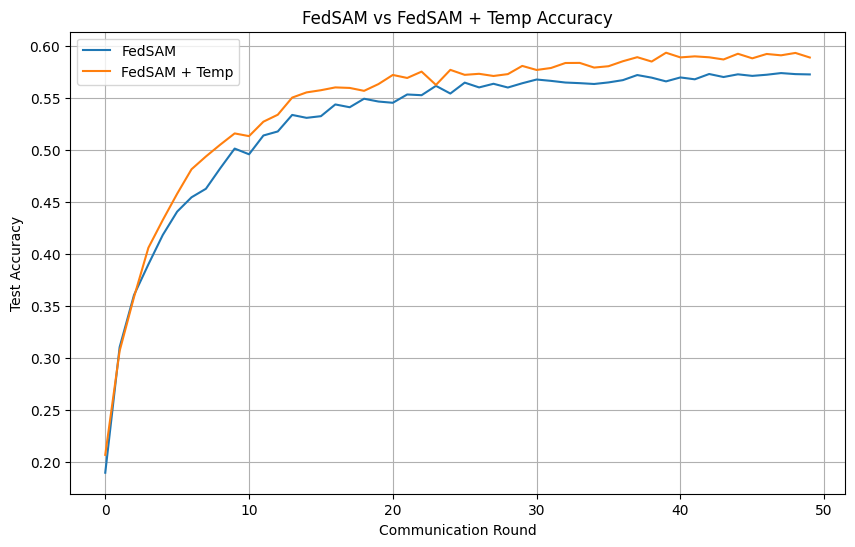

In [5]:
# Run Training
print("Training FedSAM...")
fedsam_accs, fedsam_model = run_fedsam()

print("\nTraining FedSAM + Temp...")
fedsam_temp_accs, fedsam_temp_tau, fedsam_temp_model = run_fedsam_temp()

# Plot Accuracy Comparison
plt.figure(figsize=(10, 6))
plt.plot(fedsam_accs, label='FedSAM')
plt.plot(fedsam_temp_accs, label='FedSAM + Temp')
plt.xlabel('Communication Round')
plt.ylabel('Test Accuracy')
plt.title('FedSAM vs FedSAM + Temp Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Generating loss landscapes...
Computing loss surface on 40x40 grid...
Step 0/40
Step 5/40
Step 10/40
Step 15/40
Step 20/40
Step 25/40
Step 30/40
Step 35/40
Computing loss surface on 40x40 grid...
Step 0/40
Step 5/40
Step 10/40
Step 15/40
Step 20/40
Step 25/40
Step 30/40
Step 35/40


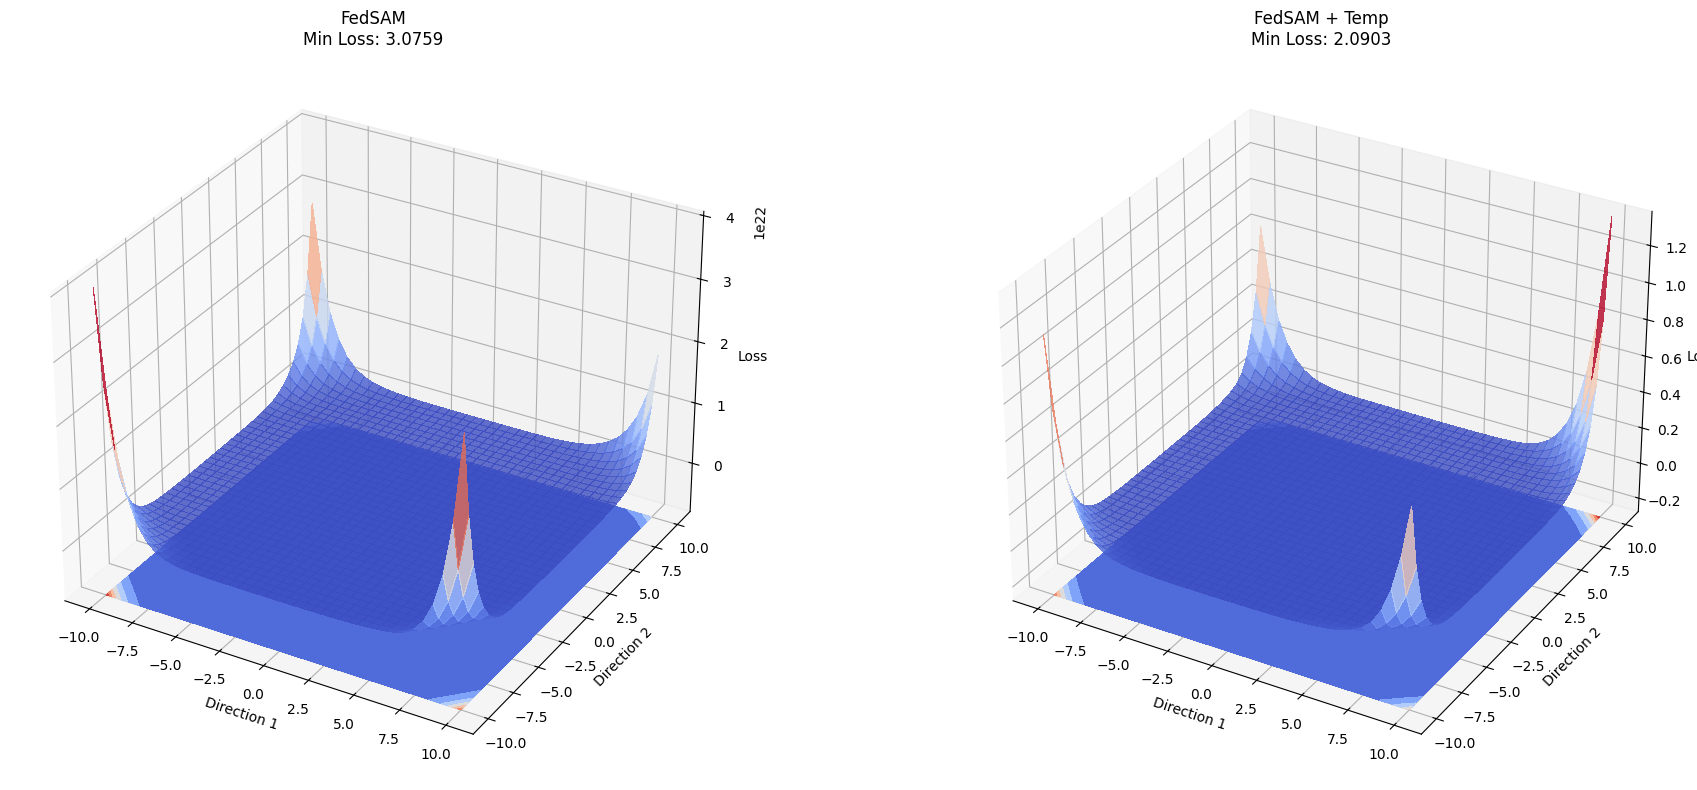

In [8]:
# ========================================
# LOSS LANDSCAPE VISUALIZATION
# ========================================
from mpl_toolkits.mplot3d import Axes3D

def get_random_directions(model):
    """Generate two random directions for the model parameters."""
    x_direction = []
    y_direction = []
    for p in model.parameters():
        x_d = torch.randn_like(p)
        y_d = torch.randn_like(p)
        x_direction.append(x_d)
        y_direction.append(y_d)
    return x_direction, y_direction

def normalize_directions_for_weights(direction, weights):
    """Normalize directions filter-wise."""
    normalized_direction = []
    # Convert generator to list if needed
    weights_list = list(weights)

    for d, w in zip(direction, weights_list):
        if d.dim() <= 1:
            # For scalars or 1D tensors, just normalize by norm
            norm_d = d.norm() + 1e-10
            norm_w = w.norm() + 1e-10
            normalized_direction.append(d * (norm_w / norm_d))
        else:
            # For higher dim tensors (conv weights), normalize filter-wise
            # w shape: [out_channels, in_channels, kH, kW]
            # We want to normalize each filter (out_channel)
            # Reshape to [out_channels, -1]
            d_reshaped = d.view(d.size(0), -1)
            w_reshaped = w.view(w.size(0), -1)

            norm_d = d_reshaped.norm(dim=1, keepdim=True) + 1e-10
            norm_w = w_reshaped.norm(dim=1, keepdim=True) + 1e-10

            # Reshape norm factor to broadcast
            norm_factor = (norm_w / norm_d).view(d.size(0), *([1]*(d.dim()-1)))
            normalized_direction.append(d * norm_factor)
    return normalized_direction

def compute_loss_surface(model, loader, x_dir, y_dir, steps=20, range_val=1.0, device='cuda'):
    """Compute loss surface."""
    model.eval()
    criterion = nn.CrossEntropyLoss()

    # Create grid
    x = np.linspace(-range_val, range_val, steps)
    y = np.linspace(-range_val, range_val, steps)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    # Save original weights
    original_weights = [p.clone() for p in model.parameters()]

    # Normalize directions
    x_dir = normalize_directions_for_weights(x_dir, model.parameters())
    y_dir = normalize_directions_for_weights(y_dir, model.parameters())

    # Use a subset of data for faster evaluation
    data_subset = []
    subset_size = 1024 # Adjust based on memory/speed
    count = 0
    for inputs, targets in loader:
        data_subset.append((inputs, targets))
        count += inputs.size(0)
        if count >= subset_size:
            break

    print(f"Computing loss surface on {steps}x{steps} grid...")

    with torch.no_grad():
        for i in range(steps):
            if i % 5 == 0:
                print(f"Step {i}/{steps}")
            for j in range(steps):
                # Perturb weights: theta + alpha * delta + beta * eta
                alpha = X[i, j]
                beta = Y[i, j]

                for k, p in enumerate(model.parameters()):
                    # Move direction to same device as parameter
                    d1 = x_dir[k].to(p.device)
                    d2 = y_dir[k].to(p.device)
                    p.data = original_weights[k] + alpha * d1 + beta * d2

                # Compute loss
                loss_sum = 0
                total = 0
                for inputs, targets in data_subset:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    if isinstance(outputs, tuple):
                        _, outputs = outputs
                    loss = criterion(outputs, targets)
                    loss_sum += loss.item() * inputs.size(0)
                    total += inputs.size(0)

                Z[i, j] = loss_sum / total

    # Restore original weights
    for k, p in enumerate(model.parameters()):
        p.data = original_weights[k]

    return X, Y, Z

def plot_comparison(X1, Y1, Z1, X2, Y2, Z2, title1="FedSAM", title2="FedSAM + Temp"):
    fig = plt.figure(figsize=(20, 8))

    # Plot 1
    ax1 = fig.add_subplot(121, projection='3d')
    surf1 = ax1.plot_surface(X1, Y1, Z1, cmap='coolwarm', linewidth=0, antialiased=False, alpha=0.8)

    # Add contour plot on the bottom
    z_min1 = np.min(Z1)
    z_max1 = np.max(Z1)
    offset1 = z_min1 - (z_max1 - z_min1) * 0.2
    ax1.contourf(X1, Y1, Z1, zdir='z', offset=offset1, cmap='coolwarm')

    ax1.set_title(f"{title1}\nMin Loss: {z_min1:.4f}")
    ax1.set_zlim(offset1, z_max1)
    ax1.set_xlabel('Direction 1')
    ax1.set_ylabel('Direction 2')
    ax1.set_zlabel('Loss')

    # Plot 2
    ax2 = fig.add_subplot(122, projection='3d')
    surf2 = ax2.plot_surface(X2, Y2, Z2, cmap='coolwarm', linewidth=0, antialiased=False, alpha=0.8)

    # Add contour plot on the bottom
    z_min2 = np.min(Z2)
    z_max2 = np.max(Z2)
    offset2 = z_min2 - (z_max2 - z_min2) * 0.2
    ax2.contourf(X2, Y2, Z2, zdir='z', offset=offset2, cmap='coolwarm')

    ax2.set_title(f"{title2}\nMin Loss: {z_min2:.4f}")
    ax2.set_zlim(offset2, z_max2)
    ax2.set_xlabel('Direction 1')
    ax2.set_ylabel('Direction 2')
    ax2.set_zlabel('Loss')

    plt.tight_layout()
    plt.show()

# Execute Visualization
print("Generating loss landscapes...")

# Generate directions for FedSAM
x_dir1, y_dir1 = get_random_directions(fedsam_model)
X1, Y1, Z1 = compute_loss_surface(fedsam_model, test_loader, x_dir1, y_dir1, steps=40, range_val=10.0, device=device)

# Generate directions for FedSAM + Temp
x_dir2, y_dir2 = get_random_directions(fedsam_temp_model)
X2, Y2, Z2 = compute_loss_surface(fedsam_temp_model, test_loader, x_dir2, y_dir2, steps=40, range_val=10.0, device=device)

# Plot
plot_comparison(X1, Y1, Z1, X2, Y2, Z2)

Generating loss landscapes with significantly wider range (Zoomed Out)...
Computing loss surface on 40x40 grid...
Step 0/40
Step 5/40
Step 10/40
Step 15/40
Step 20/40
Step 25/40
Step 30/40
Step 35/40
Computing loss surface on 40x40 grid...
Step 0/40
Step 5/40
Step 10/40
Step 15/40
Step 20/40
Step 25/40
Step 30/40
Step 35/40


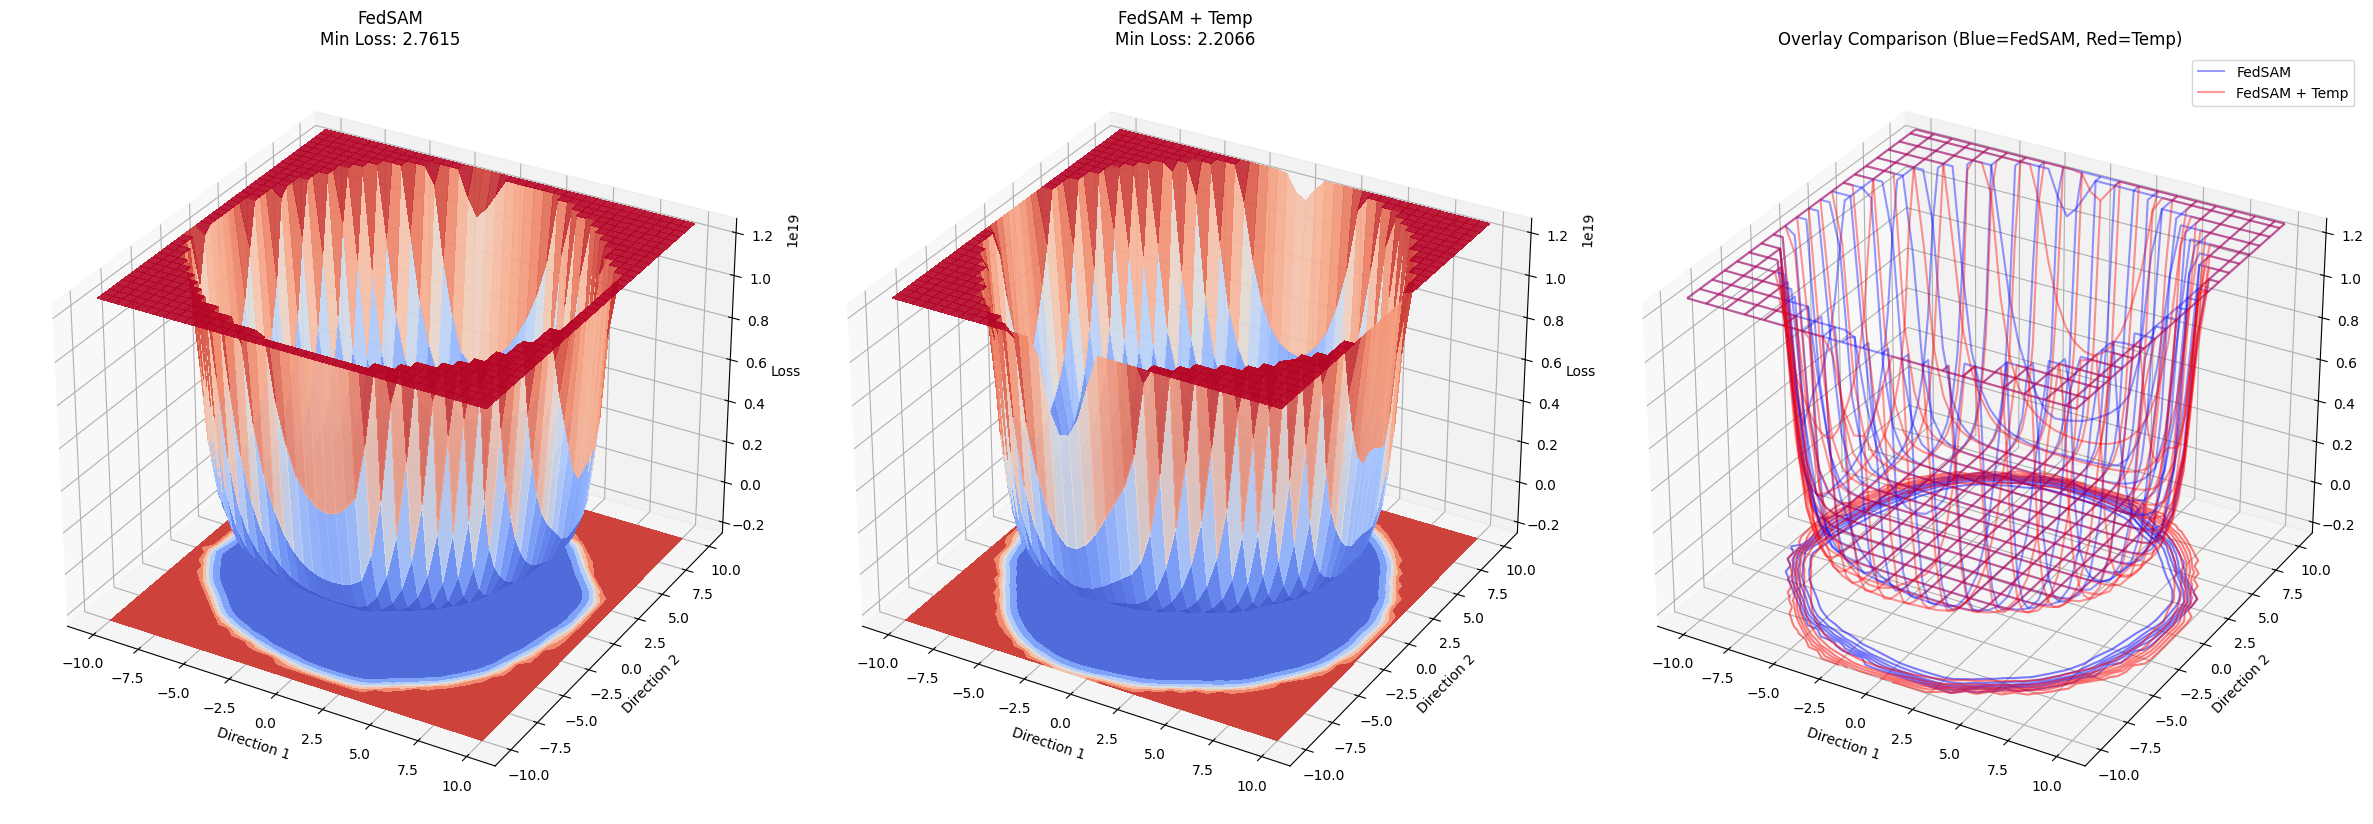

In [9]:
# ========================================
# LOSS LANDSCAPE VISUALIZATION
# ========================================
from mpl_toolkits.mplot3d import Axes3D

def get_random_directions(model):
    """Generate two random directions for the model parameters."""
    x_direction = []
    y_direction = []
    for p in model.parameters():
        x_d = torch.randn_like(p)
        y_d = torch.randn_like(p)
        x_direction.append(x_d)
        y_direction.append(y_d)
    return x_direction, y_direction

def normalize_directions_for_weights(direction, weights):
    """Normalize directions filter-wise."""
    normalized_direction = []
    # Convert generator to list if needed
    weights_list = list(weights)

    for d, w in zip(direction, weights_list):
        if d.dim() <= 1:
            # For scalars or 1D tensors, just normalize by norm
            norm_d = d.norm() + 1e-10
            norm_w = w.norm() + 1e-10
            normalized_direction.append(d * (norm_w / norm_d))
        else:
            # For higher dim tensors (conv weights), normalize filter-wise
            # w shape: [out_channels, in_channels, kH, kW]
            # We want to normalize each filter (out_channel)
            # Reshape to [out_channels, -1]
            d_reshaped = d.view(d.size(0), -1)
            w_reshaped = w.view(w.size(0), -1)

            norm_d = d_reshaped.norm(dim=1, keepdim=True) + 1e-10
            norm_w = w_reshaped.norm(dim=1, keepdim=True) + 1e-10

            # Reshape norm factor to broadcast
            norm_factor = (norm_w / norm_d).view(d.size(0), *([1]*(d.dim()-1)))
            normalized_direction.append(d * norm_factor)
    return normalized_direction

def compute_loss_surface(model, loader, x_dir, y_dir, steps=20, range_val=1.0, device='cuda'):
    """Compute loss surface."""
    model.eval()
    criterion = nn.CrossEntropyLoss()

    # Create grid
    x = np.linspace(-range_val, range_val, steps)
    y = np.linspace(-range_val, range_val, steps)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    # Save original weights
    original_weights = [p.clone() for p in model.parameters()]

    # Normalize directions
    x_dir = normalize_directions_for_weights(x_dir, model.parameters())
    y_dir = normalize_directions_for_weights(y_dir, model.parameters())

    # Use a subset of data for faster evaluation
    data_subset = []
    subset_size = 1024 # Adjust based on memory/speed
    count = 0
    for inputs, targets in loader:
        data_subset.append((inputs, targets))
        count += inputs.size(0)
        if count >= subset_size:
            break

    print(f"Computing loss surface on {steps}x{steps} grid...")

    with torch.no_grad():
        for i in range(steps):
            if i % 5 == 0:
                print(f"Step {i}/{steps}")
            for j in range(steps):
                # Perturb weights: theta + alpha * delta + beta * eta
                alpha = X[i, j]
                beta = Y[i, j]

                for k, p in enumerate(model.parameters()):
                    # Move direction to same device as parameter
                    d1 = x_dir[k].to(p.device)
                    d2 = y_dir[k].to(p.device)
                    p.data = original_weights[k] + alpha * d1 + beta * d2

                # Compute loss
                loss_sum = 0
                total = 0
                for inputs, targets in data_subset:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    if isinstance(outputs, tuple):
                        _, outputs = outputs
                    loss = criterion(outputs, targets)
                    loss_sum += loss.item() * inputs.size(0)
                    total += inputs.size(0)

                Z[i, j] = loss_sum / total

    # Restore original weights
    for k, p in enumerate(model.parameters()):
        p.data = original_weights[k]

    return X, Y, Z

def plot_comparison(X1, Y1, Z1, X2, Y2, Z2, title1="FedSAM", title2="FedSAM + Temp"):
    # Clamp values for better visualization (like the reference paper)
    # We use a percentile to determine the "ceiling" of the plot to avoid outliers
    # and create the "cup" shape seen in literature.

    # Determine a common z_limit for comparison
    # We want to see the basin, so we clamp high loss values.
    # Let's take the 70th percentile of the combined data as the ceiling.
    combined_z = np.concatenate([Z1.flatten(), Z2.flatten()])
    z_limit = np.percentile(combined_z, 70)

    # Clamp the data
    Z1_clamped = np.clip(Z1, None, z_limit)
    Z2_clamped = np.clip(Z2, None, z_limit)

    fig = plt.figure(figsize=(24, 8))

    # Common offset for contour plot
    z_min = min(np.min(Z1_clamped), np.min(Z2_clamped))
    z_max = max(np.max(Z1_clamped), np.max(Z2_clamped))
    c_offset = z_min - (z_max - z_min) * 0.2

    # Plot 1: FedSAM
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(X1, Y1, Z1_clamped, cmap='coolwarm', linewidth=0, antialiased=False, alpha=0.9)
    ax1.contourf(X1, Y1, Z1_clamped, zdir='z', offset=c_offset, cmap='coolwarm')
    ax1.set_title(f"{title1}\nMin Loss: {np.min(Z1):.4f}")
    ax1.set_zlim(c_offset, z_limit)
    ax1.set_xlabel('Direction 1')
    ax1.set_ylabel('Direction 2')
    ax1.set_zlabel('Loss')

    # Plot 2: FedSAM + Temp
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_surface(X2, Y2, Z2_clamped, cmap='coolwarm', linewidth=0, antialiased=False, alpha=0.9)
    ax2.contourf(X2, Y2, Z2_clamped, zdir='z', offset=c_offset, cmap='coolwarm')
    ax2.set_title(f"{title2}\nMin Loss: {np.min(Z2):.4f}")
    ax2.set_zlim(c_offset, z_limit)
    ax2.set_xlabel('Direction 1')
    ax2.set_ylabel('Direction 2')
    ax2.set_zlabel('Loss')

    # Plot 3: Stacked / Overlay
    ax3 = fig.add_subplot(133, projection='3d')
    # Use wireframe for overlay to see through
    ax3.plot_wireframe(X1, Y1, Z1_clamped, color='blue', alpha=0.4, label=title1, rstride=2, cstride=2)
    ax3.plot_wireframe(X2, Y2, Z2_clamped, color='red', alpha=0.4, label=title2, rstride=2, cstride=2)
    # Also add contours for both on the floor
    ax3.contour(X1, Y1, Z1_clamped, zdir='z', offset=c_offset, colors='blue', alpha=0.5)
    ax3.contour(X2, Y2, Z2_clamped, zdir='z', offset=c_offset, colors='red', alpha=0.5)

    ax3.set_title("Overlay Comparison (Blue=FedSAM, Red=Temp)")
    ax3.set_zlim(c_offset, z_limit)
    ax3.set_xlabel('Direction 1')
    ax3.set_ylabel('Direction 2')
    ax3.legend()

    plt.tight_layout()
    plt.show()

# Execute Visualization
print("Generating loss landscapes with significantly wider range (Zoomed Out)...")

# Generate directions for FedSAM
x_dir1, y_dir1 = get_random_directions(fedsam_model)
# Increased range_val to 10.0 for a zoomed out view and steps to 40
X1, Y1, Z1 = compute_loss_surface(fedsam_model, test_loader, x_dir1, y_dir1, steps=40, range_val=10.0, device=device)

# Generate directions for FedSAM + Temp
x_dir2, y_dir2 = get_random_directions(fedsam_temp_model)
# Increased range_val to 10.0 for a zoomed out view and steps to 40
X2, Y2, Z2 = compute_loss_surface(fedsam_temp_model, test_loader, x_dir2, y_dir2, steps=40, range_val=10.0, device=device)

# Plot
plot_comparison(X1, Y1, Z1, X2, Y2, Z2)